***Vorlesung 'Syntax natürlicher Sprachen', WS 2019/20***

---
# PCFG: Abschätzung von Regelwahrscheinlichkeiten aus CFG-Korpusdaten

In [84]:
import nltk

---
## 1: Herunterladen von Ressourcen

#### Laden Sie sich zunächst die Ressource `corpora/treebank` über den NLTK Download-Manager herunter.

In [85]:
# nltk.download()

---
## 2: Von Daten zu Regelwahrscheinlichkeiten

#### Gegeben sei folgende kontextfreie Grammatik:

In [86]:
cfg = """
S -> NP VP
VP -> V NP PP
VP -> V NP
NP -> DET N
NP -> NP PP
PP -> P NP

DET -> "the" | "a"
N -> "boy" | "woman" | "telescope"
V -> "saw"
P -> "with"
"""

#### Sie modelliert sehr einfache Sätze der Form `SBJ` *saw* `OBJ` mit optionaler Präpositionalphrase am Ende. Diese Präpositionalphrase kann entweder der näheren Bestimmung des Objekts oder der näheren Bestimmung der in der Verbalphrase ausgedrückten Handlung dienen.

#### Im folgenden sollen aus der Penn Treebank Wahrscheinlichkeiten für die einzelnen Regeln extrahiert werden, um dieser Ambiguität Herr zu werden.

---
### 2a: Relevante Konstruktionen erkennen

#### Nutzen das im NLTK enthaltene Sample der Penn Treebank (nach Installation unter `nltk.corpus.treebank` zu finden) zunächst zur Identifikation der für eine Disambiguierung nützlichen (Teil-)bäume der Penn Treebank.

#### *Hinweis:* Sie können sich bei der Analyse auf die häufigsten Konstruktionen der Baumbank beschränken.

In [87]:
from collections import defaultdict
from nltk.corpus import treebank

In [88]:
def find_relevant_constructions(lhs, only_with=None):
    lhs_nt = nltk.grammar.Nonterminal(lhs)
    should_filter = only_with is not None
    if should_filter:
        filter_by = list(map(nltk.grammar.Nonterminal, only_with))
        def passes_filter(tup):
            for f in filter_by:
                if f not in tup:
                    return False
            return True

    counter = defaultdict(int)
    ### TODO: zähle Produktionen in treebank mit lhs als linker Seite ###
    ### und einer rechten Seite, für die passes_filter True liefert ###
    for tree in treebank.parsed_sents():  # [(S (NP DET N) (VP V NP))]
        for prod in tree.productions():   # [(S, NP VP), (NP, DET N)]
            if prod.lhs() == lhs_nt:
                if not should_filter or passes_filter(prod.rhs()):
                    counter[prod] += 1

    return [ (k, counter[k]) for k in sorted(counter.keys(), key=counter.__getitem__) ]

---
### 2b: Regelwahrscheinlichkeiten abschätzen

#### Zählen Sie nun, wie oft die NP+PP-Konstruktion in der Penn Treebank vorkommt und berechnen Sie die relativen Häufigkeiten als Approximation der Regelwahrscheinlichkeiten. Das Vorgehen wird in folgender Formel veranschaulicht:

$$P(N\!P, P\!P \mid N\!P) = \dfrac{count(N\!P \rightarrow \:N\!P\:P\!P)}{count(N\!P \rightarrow \setminus*)}$$



In [104]:
constructions = find_relevant_constructions('NP')
constructions[-10:]

[(NP -> NP SBAR, 409),
 (NP -> JJ NNS, 653),
 (NP -> NNP NNP, 734),
 (NP -> DT JJ NN, 740),
 (NP -> NNP, 837),
 (NP -> NNS, 996),
 (NP -> NN, 1110),
 (NP -> -NONE-, 1225),
 (NP -> DT NN, 2020),
 (NP -> NP PP, 2188)]

In [90]:

np_np_pp_frq = 2188
np_n_without_frq = 2020 + 1110 + 996 + 837 + 740 + 734 + 653
np_with_pp = np_np_pp_frq / (np_np_pp_frq + np_n_without_frq)
np_without = np_n_without_frq / (np_np_pp_frq + np_n_without_frq)


In [106]:
constructions = find_relevant_constructions('NP', ('NP', 'PP'))
constructions[-5:]

[(NP -> NP PP PP-LOC, 40),
 (NP -> NP , PP, 41),
 (NP -> NP PP SBAR, 49),
 (NP -> NP PP PP, 64),
 (NP -> NP PP, 2188)]

---

#### Zählen Sie nun auch für die V+NP+PP-Konstruktion (sowie für die DT-Erweiterungen nach *a* bzw. *the*), wie oft sie in der Penn Treebank vorkommen und berechnen Sie die relativen Häufigkeiten als Approximation der Regelwahrscheinlichkeiten:

$$P(V, N\!P, P\!P \mid V\!P) = \dfrac{count(V\!P \rightarrow V\:N\!P\:P\!P)}{count(V\!P \rightarrow \setminus*)}$$

In [111]:
constructions = find_relevant_constructions('VP')
constructions[-30:]

[(VP -> MD RB VP, 82),
 (VP -> VBN VP, 84),
 (VP -> VBZ ADJP-PRD, 87),
 (VP -> VBP S, 88),
 (VP -> VB NP PP-CLR, 88),
 (VP -> VBG S, 89),
 (VP -> VB PP-CLR, 107),
 (VP -> VBP SBAR, 121),
 (VP -> VBN S, 141),
 (VP -> VB S, 155),
 (VP -> VBZ NP-PRD, 163),
 (VP -> VBN NP PP, 170),
 (VP -> VBN NP PP-CLR, 178),
 (VP -> VBP NP, 185),
 (VP -> VBZ SBAR, 197),
 (VP -> VBZ S, 215),
 (VP -> VBD S, 223),
 (VP -> VP CC VP, 234),
 (VP -> VBN NP, 250),
 (VP -> VB VP, 258),
 (VP -> VBZ NP, 261),
 (VP -> VBP VP, 337),
 (VP -> VBD VP, 361),
 (VP -> VBG NP, 375),
 (VP -> VBD NP, 378),
 (VP -> VBZ VP, 459),
 (VP -> VBD SBAR, 631),
 (VP -> MD VP, 759),
 (VP -> VB NP, 805),
 (VP -> TO VP, 1257)]

In [92]:

vp_v_np_pp_frq = 178 + 170 + 88 + 66 + 59 + 52 + 48 + 38 + 34
vp_v_np_without_frq = 805 + 378 + 375 + 261 + 250 + 185
vp_with_pp = vp_v_np_pp_frq / (vp_v_np_pp_frq + vp_v_np_without_frq)
vp_without = vp_v_np_without_frq / (vp_v_np_pp_frq + vp_v_np_without_frq)


In [93]:
constructions = find_relevant_constructions('DT')
constructions[-5:]

[(DT -> 'this', 184),
 (DT -> 'an', 316),
 (DT -> 'The', 713),
 (DT -> 'a', 1874),
 (DT -> 'the', 4038)]

In [94]:

det_the_frq = 4038
det_a_frq = 1874
det_the = det_the_frq / (det_the_frq + det_a_frq)
det_a = det_a_frq / (det_the_frq + det_a_frq)


In [95]:
(vp_with_pp, vp_without, np_with_pp, np_without, det_the, det_a)

(0.24539671911617006,
 0.7546032808838299,
 0.23582668678594523,
 0.7641733132140548,
 0.6830175913396481,
 0.3169824086603518)

---
### 2c: Erstellen einer PCFG

#### Die aus den Daten extrahierten relativen Häufigkeiten sollen nun zur Erstellung einer probabilistischen kontextfreien Grammatik (PCFG)  genutzt werden.

In [96]:
pcfg = """
S -> NP VP     [1.0]
VP -> V NP PP  [{}]
VP -> V NP     [{}]
NP -> DET N    [{}]
NP -> NP PP    [{}]
PP -> P NP     [1.0]

DET -> "the"     [{}]
DET -> "a"       [{}]
N -> "boy"       [0.4]
N -> "woman"     [0.4]
N -> "telescope" [0.2]
V -> "saw"       [1.0]
P -> "with"      [1.0]
""".format(
    vp_with_pp, vp_without, np_without,
    np_with_pp, det_the, det_a
)
grammar = nltk.PCFG.fromstring(pcfg)
print(grammar)

Grammar with 13 productions (start state = S)
    S -> NP VP [1.0]
    VP -> V NP PP [0.245397]
    VP -> V NP [0.754603]
    NP -> DET N [0.764173]
    NP -> NP PP [0.235827]
    PP -> P NP [1.0]
    DET -> 'the' [0.683018]
    DET -> 'a' [0.316982]
    N -> 'boy' [0.4]
    N -> 'woman' [0.4]
    N -> 'telescope' [0.2]
    V -> 'saw' [1.0]
    P -> 'with' [1.0]


---
### 2d: Verwendung zur Disambiguierung

#### Testen Sie Ihre so erstellte Grammatik nun, indem Sie folgenden Satz parsen:

- *the boy saw a woman with a telescope*

(S
  (NP (DET the) (N boy))
  (VP
    (V saw)
    (NP (DET a) (N woman))
    (PP (P with) (NP (DET a) (N telescope))))) (p=0.00024049)


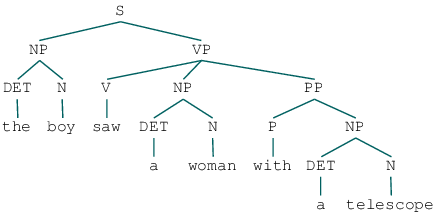

In [97]:
from IPython.display import display

parser = nltk.ViterbiParser(grammar)
for tree in parser.parse("the boy saw a woman with a telescope".split()):
    print(tree)
    display(tree)

#### Wenn Sie sich die extrahierten Wahrscheinlichkeiten und das disambiguierte Ergebnis ansehen, überrascht Sie dann das Ergebnis der Syntaxanalyse?